In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

results = pd.read_csv('results.csv', parse_dates=['date'])
shootouts = pd.read_csv('shootouts.csv', parse_dates=['date'])

# Soccer results

In [2]:
modern_date = '2010-01-01'
mod_results = results[results['date'] >= modern_date].reset_index(drop=True)   #shows only results since input date
mod_shootouts = shootouts[shootouts['date'] >= modern_date].reset_index(drop=True)   #shows only shootouts since input date
mod_full = mod_results.merge(mod_shootouts, how='outer', on=['date', 'home_team', 'away_team'])

#puts winning country in winner column, or 'Tie' otherwise, and puts 'Home', 'Away', or 'Tie' in winner_loc column
for x in range(len(mod_full)):
    if (pd.isna(mod_full['winner'][x])):   #avoids replacing values from shootouts
        if (mod_full['home_score'][x] > mod_full['away_score'][x]):
            mod_full.at[x, 'winner'] = mod_full['home_team'][x]
        else:
            if (mod_full['home_score'][x] < mod_full['away_score'][x]):
                mod_full.at[x, 'winner'] = mod_full['away_team'][x]
            else:
                mod_full.at[x, 'winner'] = 'Tie'

mod_full['winner_loc'] = ''
for x in range(len(mod_full)):
    if (mod_full['home_score'][x] > mod_full['away_score'][x]):
        mod_full.at[x, 'winner_loc'] = 'Home'
    else:
        if (mod_full['home_score'][x] < mod_full['away_score'][x]):
            mod_full.at[x, 'winner_loc'] = 'Away'
        else:
            mod_full.at[x, 'winner_loc'] = 'Tie'

mod_full.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner,winner_loc
0,2010-01-02,Iran,North Korea,1,0,Friendly,Doha,Qatar,True,Iran,Home
1,2010-01-02,Qatar,Mali,0,0,Friendly,Doha,Qatar,False,Tie,Tie
2,2010-01-02,Syria,Zimbabwe,6,0,Friendly,Kuala Lumpur,Malaysia,True,Syria,Home
3,2010-01-02,Yemen,Tajikistan,0,1,Friendly,Sana'a,Yemen,False,Tajikistan,Away
4,2010-01-03,Angola,Gambia,1,1,Friendly,Vila Real de Santo António,Portugal,True,Tie,Tie


In [3]:
eu_teams = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland',
            'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
            'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
mod_eu = mod_full[(mod_full['home_team'].isin(eu_teams)) | (mod_full['away_team'].isin(eu_teams))]
mod_eu.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner,winner_loc
41,2010-01-18,Finland,South Korea,0,2,Friendly,Málaga,Spain,True,South Korea,Away
47,2010-01-20,Oman,Sweden,0,1,Friendly,Muscat,Oman,False,Sweden,Away
48,2010-01-20,Thailand,Poland,1,3,King's Cup,Nakhon Ratchasima,Thailand,False,Poland,Away
52,2010-01-22,Latvia,South Korea,0,1,Friendly,Málaga,Spain,True,South Korea,Away
53,2010-01-23,Poland,Singapore,6,1,King's Cup,Nakhon Ratchasima,Thailand,True,Poland,Home


# Immigration Section

In [4]:
populations = pd.read_csv('Global Nations Economy -Population.csv')
populations = populations.replace(',','', regex=True)

asylum_2013 = [21030, 7145, 695, 7170, 126705, 95, 945, 8225, 4485, 66265, 1080, 26620, 1255, 195, 400, 1070, 
               18895, 2250, 13065, 17500, 15240, 500, 1495, 270, 440, 3210, 54270, 125, 55, 11930, 21305, 30585]
asylum_2014 = [22710, 11080, 1145, 14680, 202645, 155, 1450, 9430, 5615, 64310, 450, 64625, 1745, 375, 440, 
               1150, 42775, 1350, 24495, 28035, 8020, 440, 1545, 385, 330, 3620, 81185, 170, 65, 11415, 23560, 32785]
asylum_2015 = [44665, 20390, 1515, 20935, 476510, 230, 3275, 13205, 14780, 76165, 210, 83540, 2265, 330, 315, 2505, 
               177135, 1845, 44970, 88160, 12190, 895, 1260, 275, 330, 32345, 162450, 370, 150, 31115, 39445, 40160]
country_names = ['Belgium','Bulgaria', 'Czechia', 'Denmark', 'Germany', 'Estonia', 'Ireland', 'Greece', 'Spain', 
                 'France', 'Croatia', 'Italy', 'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 
                 'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia', 'Finland', 
                 'Sweden', 'Iceland', 'Liechtenstein', 'Norway', 'Switzerland', 'United Kingdom']
asylum = pd.DataFrame({'Country Name':country_names, 'asylum_2013':asylum_2013, 'asylum_2014':asylum_2014, 'asylum_2015':asylum_2015})

immigration =  pd.read_csv('./immigration_raw.csv')
immigration = immigration.rename(columns={'Year':'Country Name', '2013':'immigrants_2013', 
                                          '2014':'immigrants_2014', '2015':'immigrants_2015'})
immigration_b = immigration[['Country Name', 'immigrants_2013', 'immigrants_2014', 'immigrants_2015']]
imm_asy = immigration_b.merge(asylum, on='Country Name', how='inner')

imm_asy['rate_2013'] = imm_asy['asylum_2013']/imm_asy['immigrants_2013']
imm_asy['rate_2014'] = imm_asy['asylum_2014']/imm_asy['immigrants_2014']
imm_asy['rate_2015'] = imm_asy['asylum_2015']/imm_asy['immigrants_2015']
imm_asy.head()

,Country Name,immigrants_2013,immigrants_2014,immigrants_2015,asylum_2013,asylum_2014,asylum_2015,rate_2013,rate_2014,rate_2015
0,Belgium,120078,123158,146626,21030,22710,44665,0.175136,0.184397,0.304619
1,Bulgaria,18570,26615,25223,7145,11080,20390,0.384760,0.416307,0.808389
2,Czechia,30124,29897,29602,695,1145,1515,0.023071,0.038298,0.051179
3,Denmark,60312,68388,78492,7170,14680,20935,0.118882,0.214658,0.266715
4,Germany,692713,884893,1571047,126705,202645,476510,0.182911,0.229005,0.303307


In [5]:
fb_agg = pd.read_csv('results_year.csv')
fb_agg_period = fb_agg[(fb_agg['year'] >= 2013) & (fb_agg['year'] <= 2015)]
fb_agg_period = fb_agg_period.rename(columns={'country':'Country Name'})
fb_agg_period.head()

,Country Name,year,neutral,home_win,away_win,games_played,goal_diff,win_rate
3,Austria,2013,0,1,0,4,-5,0.250000
4,Austria,2014,0,0,0,1,0,0.000000
5,Austria,2015,0,0,1,1,3,1.000000
15,Belgium,2013,0,1,1,3,2,0.666667
16,Belgium,2014,0,1,1,2,6,1.000000


In [6]:
#don't run this code chunk more than once, it will keep adding columns to the dataframe
fb_agg_2013 = fb_agg_period[fb_agg_period['year'] == 2013][['Country Name', 'goal_diff', 'win_rate']].rename(columns={'goal_diff':'goal_diff_2013', 'win_rate':'win_rate_2013'})
fb_agg_2014 = fb_agg_period[fb_agg_period['year'] == 2014][['Country Name', 'goal_diff', 'win_rate']].rename(columns={'goal_diff':'goal_diff_2014', 'win_rate':'win_rate_2014'})
fb_agg_2015 = fb_agg_period[fb_agg_period['year'] == 2015][['Country Name', 'goal_diff', 'win_rate']].rename(columns={'goal_diff':'goal_diff_2015', 'win_rate':'win_rate_2015'})
imm_asy = imm_asy.merge(fb_agg_2013, on='Country Name', how='inner')
imm_asy = imm_asy.merge(fb_agg_2014, on='Country Name', how='inner')
imm_asy = imm_asy.merge(fb_agg_2015, on='Country Name', how='inner')
imm_asy.head()

,Country Name,immigrants_2013,immigrants_2014,immigrants_2015,asylum_2013,asylum_2014,asylum_2015,rate_2013,rate_2014,rate_2015,goal_diff_2013,win_rate_2013,goal_diff_2014,win_rate_2014,goal_diff_2015,win_rate_2015
0,Belgium,120078,123158,146626,21030,22710,44665,0.175136,0.184397,0.304619,2,0.666667,6,1.00,9,1.000000
1,Bulgaria,18570,26615,25223,7145,11080,20390,0.384760,0.416307,0.808389,6,0.500000,-1,0.00,-3,0.250000
2,Denmark,60312,68388,78492,7170,14680,20935,0.118882,0.214658,0.266715,6,0.400000,-2,0.25,-5,0.000000
3,Germany,692713,884893,1571047,126705,202645,476510,0.182911,0.229005,0.303307,6,0.750000,4,0.60,0,0.500000
4,Estonia,4109,3904,15413,95,155,230,0.023120,0.039703,0.014922,-9,0.000000,-4,0.20,2,0.666667


In [7]:
imm_asy_2013 = imm_asy[['Country Name', 'immigrants_2013', 'asylum_2013', 'rate_2013', 'win_rate_2013', 'goal_diff_2013']]
imm_asy_2014 = imm_asy[['Country Name', 'immigrants_2014', 'asylum_2014', 'rate_2014', 'win_rate_2014', 'goal_diff_2014']]
imm_asy_2015 = imm_asy[['Country Name', 'immigrants_2015', 'asylum_2015', 'rate_2015', 'win_rate_2015', 'goal_diff_2015']]
imm_asy_2015['rate_change_2013'] = imm_asy_2015['rate_2015']-imm_asy_2013['rate_2013']
imm_asy_2015['rate_change_2014'] = imm_asy_2015['rate_2015']-imm_asy_2014['rate_2014']
imm_asy_2015['win_change_2013'] = imm_asy_2015['win_rate_2015']-imm_asy_2013['win_rate_2013']
imm_asy_2015['win_change_2014'] = imm_asy_2015['win_rate_2015']-imm_asy_2014['win_rate_2014']

C:\Users\Nick\AppData\Local\Temp/ipykernel_10572/3785102766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imm_asy_2015['rate_change_2013'] = imm_asy_2015['rate_2015']-imm_asy_2013['rate_2013']
C:\Users\Nick\AppData\Local\Temp/ipykernel_10572/3785102766.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imm_asy_2015['rate_change_2014'] = imm_asy_2015['rate_2015']-imm_asy_2014['rate_2014']
C:\Users\Nick\AppData\Local\Temp/ipykernel_10572/3785102766.py:6: SettingWithCopyWarning: 
A value is trying to be

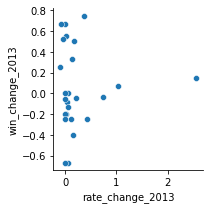

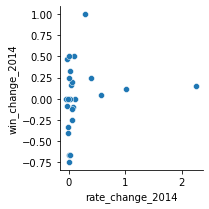

In [8]:
sns.relplot(x='rate_change_2013', y='win_change_2013', data=imm_asy_2015,height=3)
sns.relplot(x='rate_change_2014', y='win_change_2014', data=imm_asy_2015,height=3)

## Conclusion (Luke)
Neither of these results were statistically significant, indicating that we should not use the asylum numbers in our central regression

# Covid Section

In [9]:
# clean and write data to csv
cv = pd.read_csv('covid_data_raw.csv')
cv = cv[(cv["continent"]=="Europe") & (cv["indicator"] == "cases")]
cv.drop(["population", "country_code", "source", "rate_14_day", "cumulative_count", "indicator", "continent"], inplace=True, axis=1)

week_to_month = [
    "01","01","01","01","01",
    "02","02","02","02",
    "03","03","03","03",
    "04","04","04","04","04",
    "05","05","05","05",
    "06","06","06","06","06",
    "07","07","07","07",
    "08","08","08","08","08",
    "09","09","09","09",
    "10","10","10","10","10",
    "11","11","11","11",
    "12","12","12","12","12"]

cv["year_month"] = cv["year_week"].apply(lambda x: x[:5] + week_to_month[int(x[5:])])

cv.to_csv("covid_data.csv", index=False)
cv.head()

,country,weekly_count,year_week,year_month
376,Albania,2,2020-10,2020-03
377,Albania,40,2020-11,2020-03
378,Albania,47,2020-12,2020-03
379,Albania,123,2020-13,2020-04
380,Albania,149,2020-14,2020-04


In [10]:
gby = cv.groupby(["country", "year_month"]).sum().add_suffix('').reset_index()
gby.columns = ["country", "year_month", "month_count"]
gby.to_csv("covid_data_month.csv", index=False)
gby.head()

,country,year_month,month_count
0,Albania,2020-03,89
1,Albania,2020-04,637
2,Albania,2020-05,272
3,Albania,2020-06,1404
4,Albania,2020-07,2361


<AxesSubplot:xlabel='year_month'>

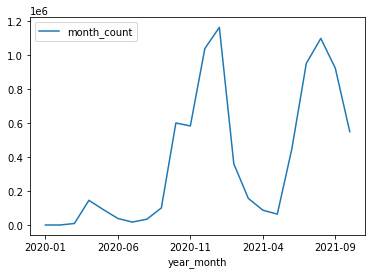

In [11]:
gby[gby["country"]=="United Kingdom"].plot(x="year_month", y="month_count", kind="line")

In [12]:
fb = pd.read_csv('./results_month.csv')
fb.head()

,country,year_month,neutral,home_win,away_win,games_played,goal_diff,win_rate
0,Austria,2010-03,0,1,0,1,1,1.0
1,Austria,2010-05,0,0,0,1,-1,0.0
2,Austria,2010-10,0,0,0,1,0,0.0
3,Austria,2010-11,0,0,0,1,-1,0.0
4,Austria,2011-02,0,0,0,1,-2,0.0


In [13]:
cv_fb = pd.merge(gby, fb, on=["country", "year_month"])
cv_fb.head()

,country,year_month,month_count,neutral,home_win,away_win,games_played,goal_diff,win_rate
0,Austria,2020-09,16248,0,0,0,1,-1,0.0
1,Austria,2020-10,67644,0,1,1,2,2,1.0
2,Austria,2020-11,167072,0,0,1,1,3,1.0
3,Austria,2021-03,77399,0,0,0,1,-4,0.0
4,Austria,2021-06,6090,1,0,0,3,-3,0.0


<AxesSubplot:xlabel='month_count', ylabel='goal_diff'>

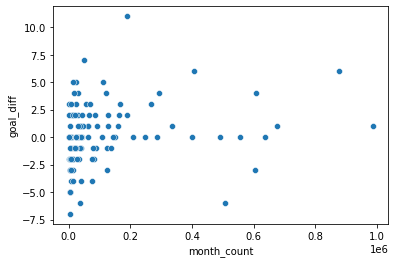

In [14]:
sns.scatterplot(data=cv_fb, x="month_count", y="goal_diff")

<AxesSubplot:xlabel='month_count', ylabel='goal_diff'>

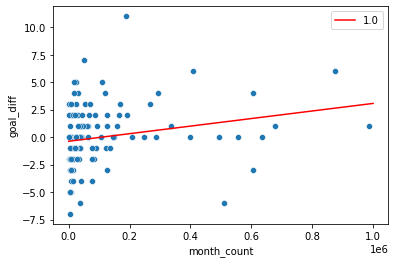

In [15]:
x = cv_fb["month_count"].to_numpy().reshape((-1, 1))
y = cv_fb["goal_diff"]
l_reg = LinearRegression().fit(x, y)

sns.scatterplot(data=cv_fb, x="month_count", y="goal_diff")

a,b = l_reg.coef_,l_reg.intercept_
x_line = np.linspace(0, 1000000, 1000)
y_line = x_line * a + b
sns.lineplot(x=x_line, y=y_line, palette=['r'], hue=np.ones(1000))

In [16]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              goal_diff   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5.996
Date:                Sun, 05 Dec 2021   Prob (F-statistic):             0.0158
Time:                        19:00:13   Log-Likelihood:                -288.02
No. Observations:                 118   AIC:                             580.0
Df Residuals:                     116   BIC:                             585.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3736      0.300     -1.246      0.2

# Immigration Section

In [17]:
imm = pd.read_csv('./immigration_raw.csv')
imm = pd.melt(imm, id_vars='Year', value_vars=["20" + str(x) for x in range(10, 20)])
imm = imm.rename(columns={"Year": "country", "variable":"year", "value":"immigration"})
imm.head()

,country,year,immigration
0,Belgium,2010,135281.0
1,Bulgaria,2010,NaN
2,Czechia,2010,48317.0
3,Denmark,2010,52236.0
4,Germany,2010,404055.0


,country,year,immigration,neutral,home_win,away_win,games_played,goal_diff,win_rate,log_immigration
0,Belgium,2010,135281.0,0,1,0,5,-2,0.200000,11.815109
2,Denmark,2010,52236.0,1,1,0,5,-3,0.200000,10.863527
3,Germany,2010,404055.0,1,1,2,6,6,0.500000,12.909306
4,Estonia,2010,2810.0,1,1,0,6,-2,0.166667,7.940940
5,Greece,2010,60462.0,0,1,1,3,2,0.666667,11.009770


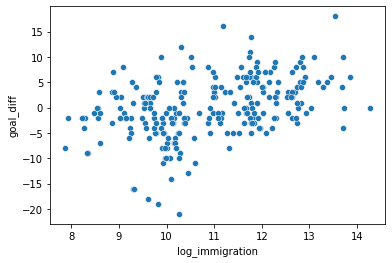

In [18]:
fb = pd.read_csv('./results_year.csv')
imm["year"] = pd.to_numeric(imm["year"])
imm_fb = pd.merge(imm, fb, on=["country", "year"])
imm_fb["log_immigration"] = np.log(imm_fb["immigration"])
imm_fb = imm_fb.dropna()
sns.scatterplot(data=imm_fb, x="log_immigration", y="goal_diff")
imm_fb.head()

<AxesSubplot:xlabel='log_immigration', ylabel='goal_diff'>

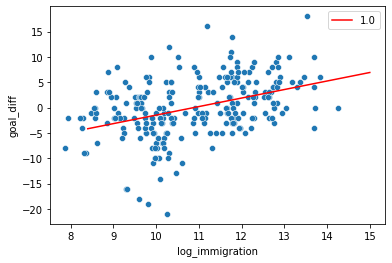

In [19]:
x = imm_fb["log_immigration"].to_numpy().reshape((-1, 1))
y = imm_fb["goal_diff"]
l_reg = LinearRegression().fit(x, y)
sns.scatterplot(data=imm_fb, x="log_immigration", y="goal_diff")

a,b = l_reg.coef_,l_reg.intercept_
x_line = np.linspace(8.4, 15, 100)
y_line = x_line * a + b
sns.lineplot(x=x_line, y=y_line, palette=['r'], hue=np.ones(100))

In [20]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              goal_diff   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     46.29
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           7.82e-11
Time:                        19:00:15   Log-Likelihood:                -763.24
No. Observations:                 246   AIC:                             1530.
Df Residuals:                     244   BIC:                             1537.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.2977      2.712     -6.746      0.0

# Sports Jobs Section

In [21]:
iso2_to_country = {
    "BE":"Belgium",
    "BG":"Bulgaria",
    "CZ":"Czechia",
    "DK":"Denmark",
    "DE":"Germany",
    "EE":"Estonia",
    "IE":"Ireland",
    "EL":"Greece",
    "ES":"Spain",
    "FR":"France",
    "HR":"Croatia",
    "IT":"Italy",
    "CY":"Cyprus",
    "LV":"Latvia",
    "LT":"Lithuania",
    "LU":"Luxembourg",
    "HU":"Hungary",
    "MT":"Malta",
    "NL":"Netherlands",
    "AT":"Austria",
    "PL":"Poland",
    "PT":"Portugal",
    "RO":"Romania",
    "SI":"Slovenia",
    "SK":"Slovakia",
    "FI":"Finland",
    "SE":"Sweden"
}
iso2 = list(iso2_to_country.keys())

# clean and write data to csv
sj = pd.read_csv('sport_jobs_raw.csv')
sj.drop(["DATAFLOW","LAST UPDATE","freq","sex","unit","OBS_FLAG"], inplace=True, axis=1)
sj = sj[sj["geo"].isin(iso2)]
sj["geo"] = sj["geo"].apply(lambda x: iso2_to_country[x])
sj.rename(columns={'geo':"country", 'TIME_PERIOD':"year", "OBS_VALUE":"employed"}, inplace=True)
sj["employed"] = sj["employed"].apply(lambda x: int(x*10000))
sj.reset_index()
sj.head()

,country,year,employed
0,Austria,2011,251000
1,Austria,2012,240000
2,Austria,2013,258000
3,Austria,2014,278000
4,Austria,2015,359000


,country,year,employed,neutral,home_win,away_win,games_played,goal_diff,win_rate,log_employed
0,Austria,2011,251000,0,1,0,6,-8,0.166667,12.433208
1,Austria,2012,240000,0,1,0,3,1,0.333333,12.388394
2,Austria,2013,258000,0,1,0,4,-5,0.250000,12.460715
3,Austria,2014,278000,0,0,0,1,0,0.000000,12.535376
4,Austria,2015,359000,0,0,1,1,3,1.000000,12.791078


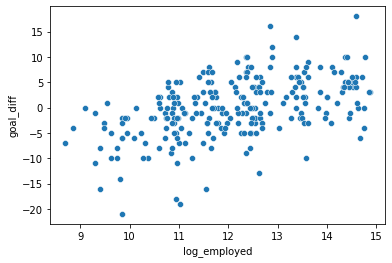

In [22]:
# Merge with fb results
fb = pd.read_csv('./results_year.csv')
sj_fb = pd.merge(sj, fb, on=["country", "year"])
sj_fb["log_employed"] = np.log(sj_fb["employed"])
sns.scatterplot(data=sj_fb, x="log_employed", y="goal_diff")
sj_fb.head()

<AxesSubplot:xlabel='log_employed', ylabel='goal_diff'>

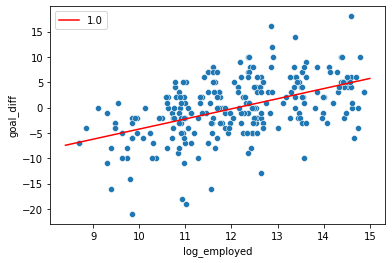

In [23]:
x = sj_fb["log_employed"].to_numpy().reshape((-1, 1))
y = sj_fb["goal_diff"]
l_reg = LinearRegression().fit(x, y)
sns.scatterplot(data=sj_fb, x="log_employed", y="goal_diff")

a,b = l_reg.coef_,l_reg.intercept_
x_line = np.linspace(8.4, 15, 100)
y_line = x_line * a + b
sns.lineplot(x=x_line, y=y_line, palette=['r'], hue=np.ones(100))

In [24]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              goal_diff   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     80.68
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           7.41e-17
Time:                        19:00:15   Log-Likelihood:                -748.49
No. Observations:                 246   AIC:                             1501.
Df Residuals:                     244   BIC:                             1508.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.2039      2.714     -8.917      0.0

# Time Series Section

### Guide from:
> https://builtin.com/data-science/time-series-python

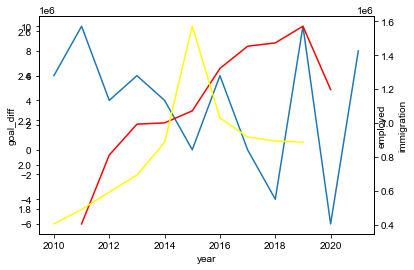

In [25]:
# Load data
fb = pd.read_csv('./results_year.csv')
sj = pd.read_csv('./sports_jobs.csv')
imm = pd.read_csv('./immigration.csv')

# clean data
country = "Germany"
s_fb = fb[(fb["country"] == country)]
s_sj = sj[sj["country"] == country]
s_imm = imm[imm["country"] == country]
# fball plot
lp1 = sns.lineplot(data=s_fb, x="year", y="goal_diff", hue="country")
lp1.legend_ = None
# employment plot
ax2 = plt.twinx()
lp2 = sns.lineplot(data=s_sj, x="year", y="employed", palette=["red"], hue="country", ax=ax2)
lp2.legend_ = None
# immigration plot
ax3 = plt.twinx()
lp3 = sns.lineplot(data=s_imm, x="year", y="immigration", palette=["yellow"], hue="country", ax=ax3)
lp3.legend_ = None
# change size
sns.set(rc={'figure.figsize':(17,13)})
lp2.grid(False)



In [26]:
# Merge
df = pd.merge(pd.merge(imm, fb, on=["country", "year"]), sj, on=["country", "year"])
df.drop(columns=["Unnamed: 0"], inplace=True)
nick_merged = df
df = df[df["country"] == "Austria"].dropna()
df['date'] = pd.to_datetime(df['year'], format='%Y')
df.index = df['date']
del df['date']
del df['country']
df


,year,immigration,neutral,home_win,away_win,games_played,goal_diff,win_rate,employed
date,,,,,,,,,
2011-01-01,2011,82230.0,0,1,0,6,-8,0.166667,251000
2012-01-01,2012,91557.0,0,1,0,3,1,0.333333,240000
2013-01-01,2013,101866.0,0,1,0,4,-5,0.250000,258000
2014-01-01,2014,116262.0,0,0,0,1,0,0.000000,278000
2015-01-01,2015,166323.0,0,0,1,1,3,1.000000,359000
2016-01-01,2016,129509.0,2,1,0,5,-3,0.200000,279000
2017-01-01,2017,111801.0,0,0,0,1,0,0.000000,263000
2018-01-01,2018,105633.0,0,3,1,5,8,0.800000,241000
2019-01-01,2019,109167.0,0,2,1,6,6,0.500000,309000


<AxesSubplot:xlabel='date', ylabel='goal_diff'>

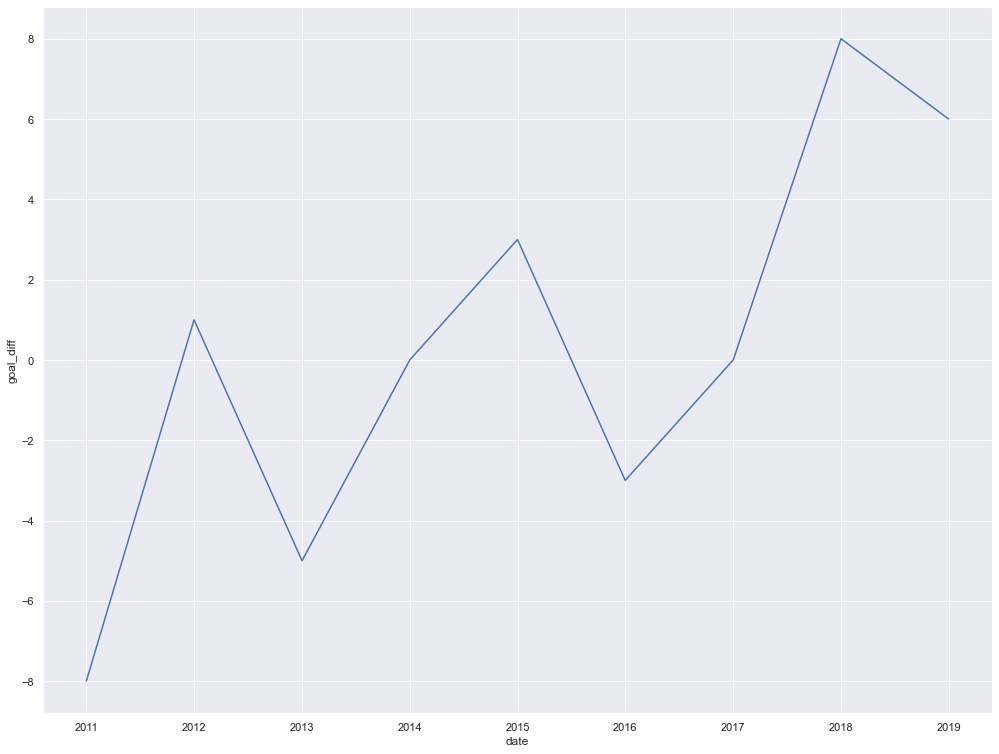

In [27]:
sns.lineplot(data=df, x="date", y="goal_diff")

<AxesSubplot:xlabel='date', ylabel='goal_diff'>

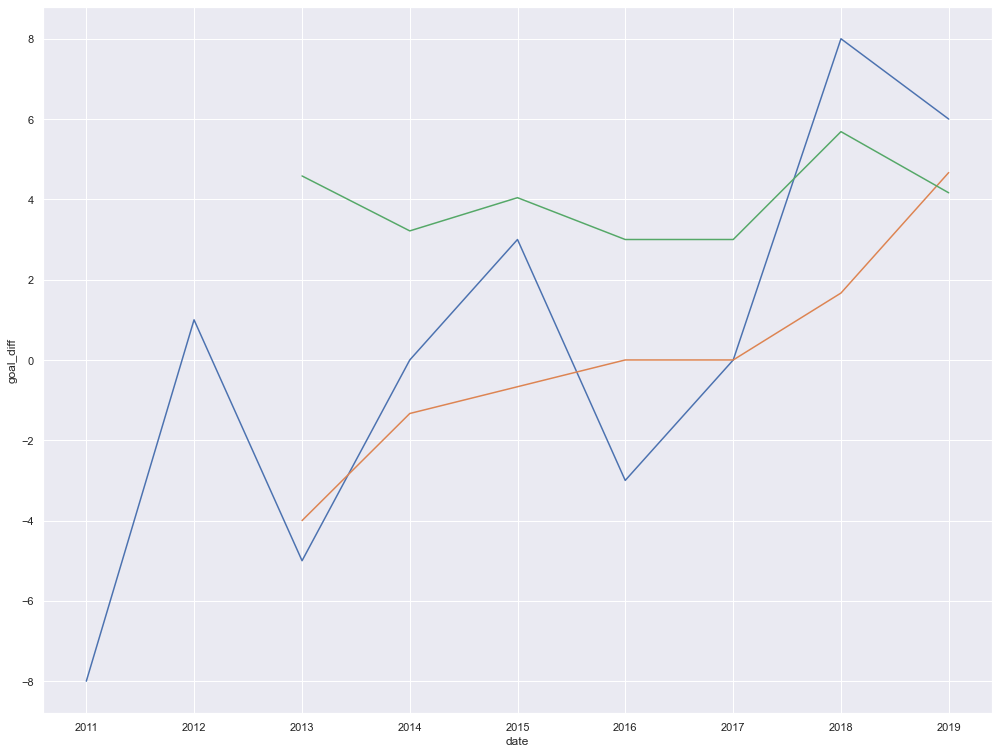

In [28]:
rolling_mean = df.rolling(3).mean()
rolling_std = df.rolling(3).std()
sns.lineplot(data=df, x="date", y="goal_diff")
sns.lineplot(data=rolling_mean, x="date", y="goal_diff")
sns.lineplot(data=rolling_std, x="date", y="goal_diff")

In [29]:
adft = adfuller(df["goal_diff"], autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']] , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)
# "We can see that our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value"

     Values                       Metric
0 -2.327793              Test Statistics
1  0.163161                      p-value
2  0.000000             No. of lags used
3  8.000000  Number of observations used
4 -4.665186          critical value (1%)
5 -3.367187          critical value (5%)
6 -2.802961         critical value (10%)


In [30]:
autocorrelation_lag1 = df['goal_diff'].autocorr(lag=1)
print("One year lag: ", autocorrelation_lag1)

One year lag:  0.20733582861790592


C:\Users\Nick\AppData\Local\Temp/ipykernel_10572/3192544242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['goal_diff']
C:\Users\Nick\AppData\Local\Temp/ipykernel_10572/3192544242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['goal_diff']


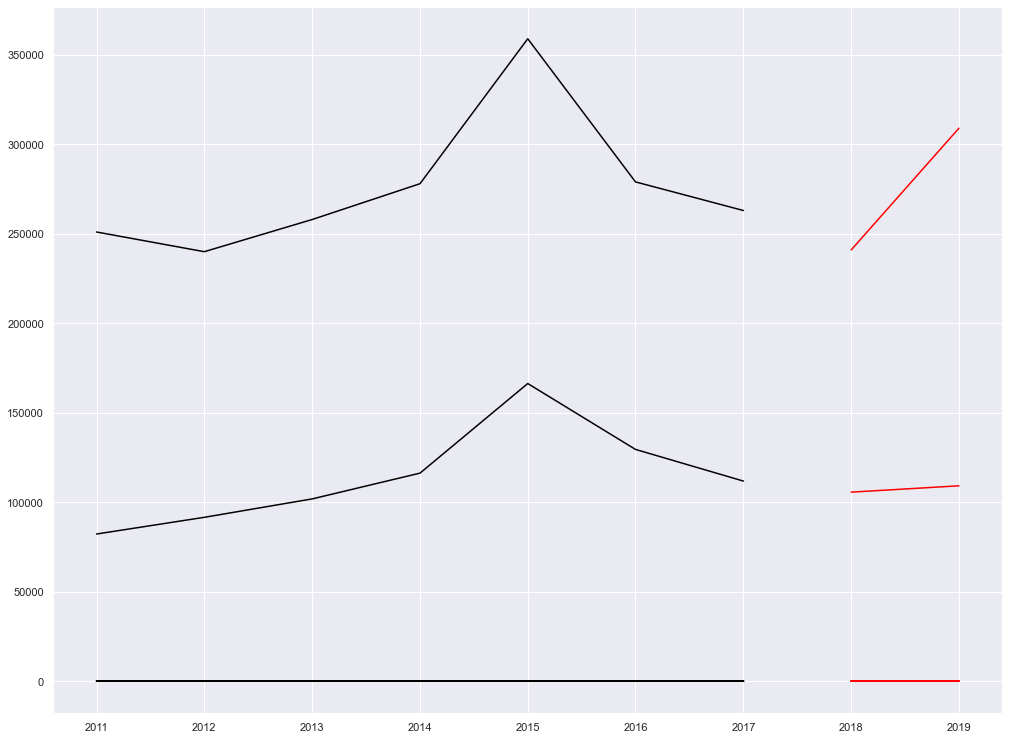

In [31]:
train = df[df['year'] < 2018]
train['train'] = train['goal_diff']
del train['year']
del train['goal_diff']
test = df[df['year'] >= 2018]
test['test'] = test['goal_diff']
del test['year']
del test['goal_diff']

plt.plot(train, color = "black")
plt.plot(test, color = "red")
sns.set()
plt.show()

In [32]:
train = train["train"]
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast, index = test.index, columns=['Prediction'])
forecast.head()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=43.817, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=41.540, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.826, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=41.019, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.302 seconds


,Prediction
date,
2018-01-01,0.0
2019-01-01,0.0


# Ranking vs GDP

In [33]:
ranking = pd.read_csv("fifa_ranking.csv")
ranking  = ranking.rename(columns={"rank":"Rank"})
ranking.head()

,Rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [34]:
# timeline between 2014 t0 2018
ranking = ranking[ranking.rank_date.str.startswith(( '2014', '2015', '2016', '2017', '2018'))]

In [35]:
# multiple rank dates with in same year
ranking[ranking.rank_date.str.startswith("2018")].rank_date.value_counts()

2018-01-18    211
2018-02-15    211
2018-03-15    211
2018-04-12    211
2018-05-17    211
2018-06-07    211
Name: rank_date, dtype: int64

In [36]:
# select values from latest in each year
latest_dates = []
for year in ['2014', '2015', '2016', '2017', '2018']:
    latest_dates.append(max(ranking[ranking.rank_date.str.startswith(year)].rank_date))
latest_dates

['2014-12-18', '2015-12-03', '2016-12-22', '2017-12-21', '2018-06-07']

In [37]:
ranking[ranking.rank_change == max(ranking.rank_change)]

,Rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
48653,105,Faroe Islands,FRO,317.21,42,82,270.27,270.27,18.89,9.44,0.0,0.0,187.5,37.5,UEFA,2014-11-27


In [38]:
ranking = ranking[ranking.rank_date.isin(latest_dates)]
ranking.shape

(1052, 16)

In [39]:
# So take the year, later adjust for selection 
ranking["year"] = ranking.rank_date.str.slice(0,4)
ranking.head()

,Rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date,year
48759,1,Germany,GER,1725.29,1725,0,1090.54,1090.54,566.83,283.42,765.86,229.76,607.88,121.58,UEFA,2014-12-18,2014
48760,2,Argentina,ARG,1538.29,1538,0,937.59,937.59,590.90,295.45,733.76,220.13,425.62,85.12,CONMEBOL,2014-12-18,2014
48761,3,Colombia,COL,1449.77,1450,0,805.97,805.97,632.31,316.15,794.27,238.28,446.83,89.37,CONMEBOL,2014-12-18,2014
48762,4,Belgium,BEL,1417.27,1417,0,849.03,849.03,652.93,326.46,542.17,162.65,395.59,79.12,UEFA,2014-12-18,2014
48763,5,Netherlands,NED,1374.24,1374,0,884.29,884.29,527.71,263.86,428.54,128.56,487.68,97.54,UEFA,2014-12-18,2014


In [40]:
gdp_growth = pd.read_csv("Global Nations Economy -GDP Growth.csv")
gdp_per_capita = pd.read_csv("Global Nations Economy -GDP Per Capita.csv")
gdp_val = pd.read_csv("Global Nations Economy -GDP.csv")
gdp_population = pd.read_csv("Global Nations Economy -Population.csv")
gdp_per_capita = gdp_per_capita.melt(id_vars="Country Name", value_vars=gdp_per_capita.columns[1:],var_name="year",value_name="gdp_per_capita")
gdp_per_capita.rename(columns={"Country Name": "country"},inplace=True)
gdp_val = gdp_val.melt(id_vars="Country Name", value_vars=gdp_val.columns[1:],var_name="year",value_name="gdp_val")
gdp_val.rename(columns={"Country Name": "country"},inplace=True)


In [41]:
gdp_per_capita.head()

,country,year,gdp_per_capita
0,Monaco,2018,"$185,979"
1,Liechtenstein,2018,"$180,367"
2,Luxembourg,2018,"$116,654"
3,Bermuda,2018,"$113,023"
4,Isle Of Man,2018,"$89,113"


In [42]:
rpl_dic = {"St. Kitts And Nevis": "St Kitts and Nevis",
                                "Turks And Caicos Islands":"Turks and Caicos Islands",
                                "St. Lucia": "St Lucia",
                                "Trinidad And Tobago" : "Trinidad and Tobago",
                                "St. Vincent And The Grenadines":"St Vincent and the Grenadines",
                                "Macao": "Macau",
                                "North Macedonia":"FYR Macedonia",
                                "Virgin Islands (U.S.)": "US Virgin Islands",
                                "Antigua And Barbuda" : "Antigua and Barbuda",
                                "China":"China PR",
                                'Ireland':'Republic of Ireland',
                                'United Kingdom': 'England',
                                'Brunei':'Brunei Darussalam',
                                'Cabo Verde':'Cape Verde Islands',
                                'China' : "China PR",
                                'Congo, Dem. Rep.': "Congo DR",
                                'Congo, Rep.': 'Congo',
                                'Curacao':'Curaçao',
                                'Iran' :'IR Iran',
                                'Lao PDR': 'Laos',
                                'United States': 'USA',
                                'UAE': 'United Arab Emirates'
}                        

In [43]:
gdp_per_capita.country.replace(rpl_dic,inplace=True)
gdp_val.country.replace(rpl_dic,inplace=True)

In [44]:
merged = pd.merge(ranking,gdp_per_capita, how="left",left_on=["country_full","year"], right_on=["country","year"])
merged  = pd.merge(merged,gdp_val,how="left",left_on=["country_full","year"], right_on=["country","year"] )
merged.drop(columns=["country_full"],inplace=True)
merged.dropna(inplace=True)

In [45]:
# convert dollar currency to float
merged.gdp_per_capita=merged.gdp_per_capita.replace('[\$,]', '', regex=True).astype(float)
merged.gdp_val=merged.gdp_val.replace('[\$,]', '', regex=True).astype(float)

In [46]:
merged.head()

,Rank,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date,year,country_x,gdp_per_capita,country_y,gdp_val
0,1,GER,1725.29,1725,0,1090.54,1090.54,566.83,283.42,765.86,229.76,607.88,121.58,UEFA,2014-12-18,2014,Germany,48024.0,Germany,3.889093e+12
1,2,ARG,1538.29,1538,0,937.59,937.59,590.90,295.45,733.76,220.13,425.62,85.12,CONMEBOL,2014-12-18,2014,Argentina,12335.0,Argentina,5.263197e+11
2,3,COL,1449.77,1450,0,805.97,805.97,632.31,316.15,794.27,238.28,446.83,89.37,CONMEBOL,2014-12-18,2014,Colombia,8114.0,Colombia,3.811121e+11
3,4,BEL,1417.27,1417,0,849.03,849.03,652.93,326.46,542.17,162.65,395.59,79.12,UEFA,2014-12-18,2014,Belgium,47764.0,Belgium,5.353902e+11
4,5,NED,1374.24,1374,0,884.29,884.29,527.71,263.86,428.54,128.56,487.68,97.54,UEFA,2014-12-18,2014,Netherlands,52901.0,Netherlands,8.921680e+11


In [47]:
merged =merged[['Rank', 'country_abrv', 'total_points', 'previous_points',
       'rank_change', 'rank_date', 'year', 'country_x', 'gdp_per_capita',
       'gdp_val']]
merged.rename(columns = {"country_x":"country"},inplace=True)

In [48]:
merged["log_val"] = np.log(merged["gdp_val"])
# merged.to_csv("rank_gdp.csv")

C:\Users\Nick\miniconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [49]:
merged.head()

,Rank,country_abrv,total_points,previous_points,rank_change,rank_date,year,country,gdp_per_capita,gdp_val,log_val
0,1,GER,1725.29,1725,0,2014-12-18,2014,Germany,48024.0,3.889093e+12,28.989197
1,2,ARG,1538.29,1538,0,2014-12-18,2014,Argentina,12335.0,5.263197e+11,26.989175
2,3,COL,1449.77,1450,0,2014-12-18,2014,Colombia,8114.0,3.811121e+11,26.666359
3,4,BEL,1417.27,1417,0,2014-12-18,2014,Belgium,47764.0,5.353902e+11,27.006262
4,5,NED,1374.24,1374,0,2014-12-18,2014,Netherlands,52901.0,8.921680e+11,27.516920


C:\Users\Nick\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


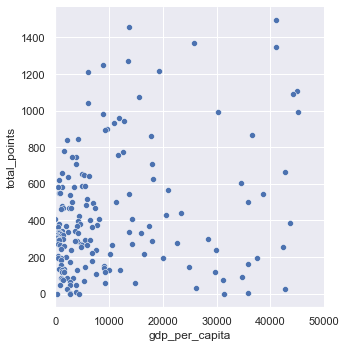

In [50]:
g = sns.relplot("gdp_per_capita","total_points",data = merged[merged.year=="2015"])
g.set(xlim=(0, 50000))


C:\Users\Nick\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


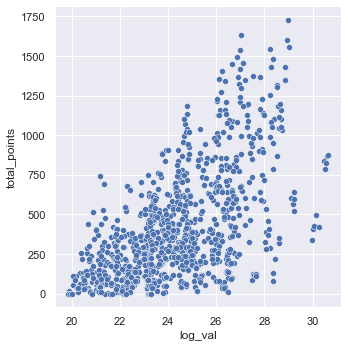

In [51]:
g = sns.relplot("log_val","total_points",data =  merged)

In [52]:
on_total= merged.groupby(["total_points"]).agg({"gdp_per_capita":"mean","country":"max"})
# sns.relplot("Rank","total_points",data=on_total)
on_total

,gdp_per_capita,country
total_points,,
0.00,11623.375,Turks and Caicos Islands
4.25,2679.000,Papua New Guinea
4.30,2464.000,Djibouti
5.28,74990.000,Cayman Islands
5.58,35771.000,Andorra
...,...,...
1544.05,8710.000,Brazil
1558.49,47811.000,Germany
1601.91,44553.000,Germany


In [53]:
nick_merged.head()

,country,year,immigration,neutral,home_win,away_win,games_played,goal_diff,win_rate,employed
0,Belgium,2011,147377.0,0,1,1,6,1,0.333333,235000
1,Bulgaria,2011,NaN,0,0,1,1,1,1.000000,102000
2,Denmark,2011,52833.0,0,3,2,5,8,1.000000,257000
3,Germany,2011,489422.0,0,3,1,6,10,0.666667,1733000
4,Estonia,2011,3709.0,0,0,1,2,-2,0.500000,34000


In [54]:
merged["year"] = merged["year"].astype(int)
tmp = pd.merge(imm, merged, on=["country", "year"])
tmp = pd.merge(sj, tmp, on=["country", "year"])
final_merged = pd.merge(fb, tmp, on=["country", "year"])
final_merged["log_imm"] = np.log(final_merged["immigration"])
final_merged["log_employed"] = np.log(final_merged["employed"])
final_merged.head()

,country,year,neutral,home_win,away_win,games_played,goal_diff,win_rate,employed,Unnamed: 0,...,country_abrv,total_points,previous_points,rank_change,rank_date,gdp_per_capita,gdp_val,log_val,log_imm,log_employed
0,Austria,2014,0,0,0,1,0,0.0,278000,155,...,AUT,862.77,863,0,2014-12-18,51786.0,4.425848e+11,26.815898,11.663602,12.535376
1,Austria,2015,0,0,1,1,3,1.0,359000,189,...,AUT,1090.67,1130,0,2015-12-03,44196.0,3.819711e+11,26.668611,12.021687,12.791078
2,Austria,2016,2,1,0,5,-3,0.2,279000,223,...,AUT,773.49,773,0,2016-12-22,45308.0,3.958374e+11,26.704269,11.771506,12.538967
3,Austria,2017,0,0,0,1,0,0.0,263000,257,...,AUT,815.41,815,0,2017-12-21,47427.0,4.172379e+11,26.756922,11.624476,12.479909
4,Austria,2018,0,3,1,5,8,0.8,241000,291,...,AUT,844.70,841,0,2018-06-07,51478.0,4.550949e+11,26.843772,11.567726,12.392552


In [55]:
X = final_merged[['log_imm', 'log_employed', 'log_val']] 
y = final_merged['total_points']

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     73.71
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           9.39e-27
Time:                        19:00:23   Log-Likelihood:                -822.69
No. Observations:                 120   AIC:                             1653.
Df Residuals:                     116   BIC:                             1665.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4331.2223    709.723     -6.103   